# Objective 
Evaluate all calibrated ensemble outputs

In [1]:
import glob,os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
outdir = '/glade/p/work/manab/ff/islandpark/output/allens'
prms = sorted(glob.glob(outdir + '/*_111_runs_best*.nc'))
hechms = sorted(glob.glob(outdir + '/*_222_runs_best*.nc'))
vic = sorted(glob.glob(outdir + '/*_333_runs_best*.nc'))
sacsma = sorted(glob.glob(outdir + '/*_444_runs_best*.nc'))

prmsparam = sorted(glob.glob(outdir + '/*_111_para_best*.nc'))
hechmsparam = sorted(glob.glob(outdir + '/*_222_para_best*.nc'))
vicparam = sorted(glob.glob(outdir + '/*_333_para_best*.nc'))
sacsmaparam = sorted(glob.glob(outdir + '/*_444_para_best*.nc'))

In [29]:
def qextract(nclist):
    '''
    Extracts q from each ensemble and concatenates them 
    into a single array
    
    nclist: List of all ensembles
    '''
    ncdat = np.empty([37,])
    for count, value in enumerate(nclist):
        ncout = xr.open_dataset(value)
        ncout = ncout.groupby('time.year').max()
        ncout = ncout.where((ncout.year > 1979), drop = True)
        q = ncout['q_routed'].values
        ncdat = np.c_[ncdat, q]
    ncdat = np.delete(ncdat,(0), axis=1)
    return(ncdat)

In [4]:
def vextract(nclist, ncvar):
    '''
    Extracts any variable from each ensemble and concatenates them 
    into a single array
    
    nclist: List of all ensembles
    ncvar: Variable to be extracted
    '''
    var = np.empty([1,])
    for count, value in enumerate(nclist):
        nc = xr.open_dataset(value)
        ncv = nc[ncvar].values
        var = np.c_[var, ncv]
    
    var = np.delete(var,(0), axis=1)
    return(var)

In [6]:
# Prepare simulation data
prmsq = qextract(prms)
hechmsq = qextract(hechms)
vicq = qextract(vic)
sacsmaq = qextract(sacsma)

In [7]:
# Prepare observation data 
ncout = xr.open_dataset(prms[1])
ncout = ncout.groupby('time.year').max()
ncout = ncout.where((ncout.year > 1979), drop = True)
qobs = ncout['obsq'].values

# FLOW DURATION CURVES

In [30]:
def plotfdc(qdat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot exceedances of FUSE model outputs
    
    qdat: Simulation data
    qobs: Observation data
    pylabel: Y-axis plot label
    ptitle: Title of the plot
    psave: Plot name for saving
    
    '''
    # Calculate exceedance levels of sim data
    exceedanceens = np.arange(1.,len(qdat)+1) /len(qdat)
    sortens = np.sort(qdat, axis=0)[::-1]

    qmeandat = qdat.mean(axis=1)
    
    # Calculate exceedance levels of mean simulated data
    exceedancemean = np.arange(1.,len(qmeandat)+1) /len(qmeandat)
    sortmean = np.sort(qmeandat, axis=0)[::-1]
    
    # Calculate exceedance levels of obs data
    exceedanceobs = np.arange(1.,len(obsdat)+1) /len(obsdat)
    sortobs = np.sort(obsdat, axis=0)[::-1]
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8))
    plt.fill_between(exceedanceens*100, np.min(sortens, axis=1),np.max(sortens, axis=1), label = "Sim Q Ensemble")
    plt.plot(exceedancemean*100, sortmean, label = 'Sim Q Mean', color='red')
    plt.plot(exceedanceobs*100, sortobs, label = 'Obs Q', color='black')
    plt.xlabel("Exceedence [%]")
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()

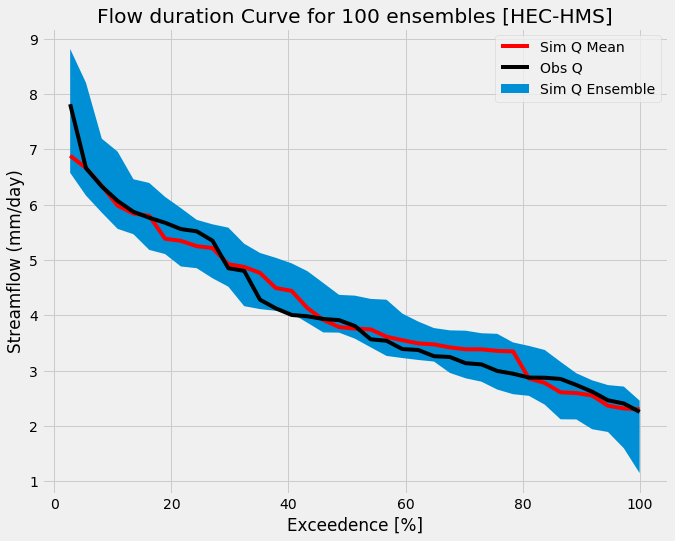

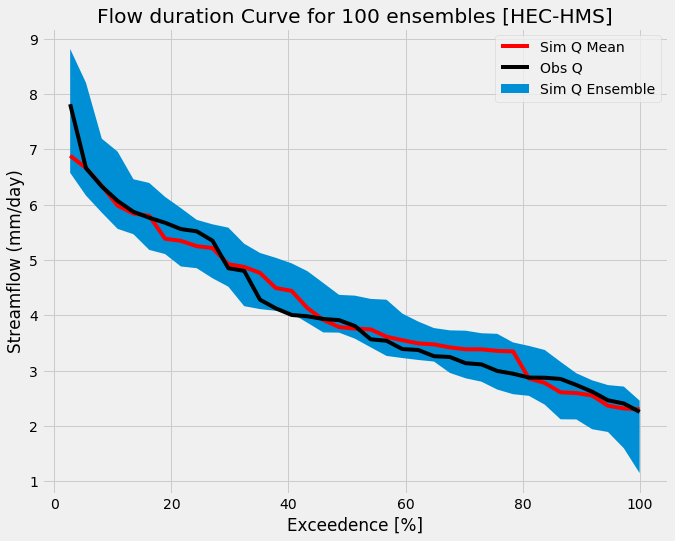

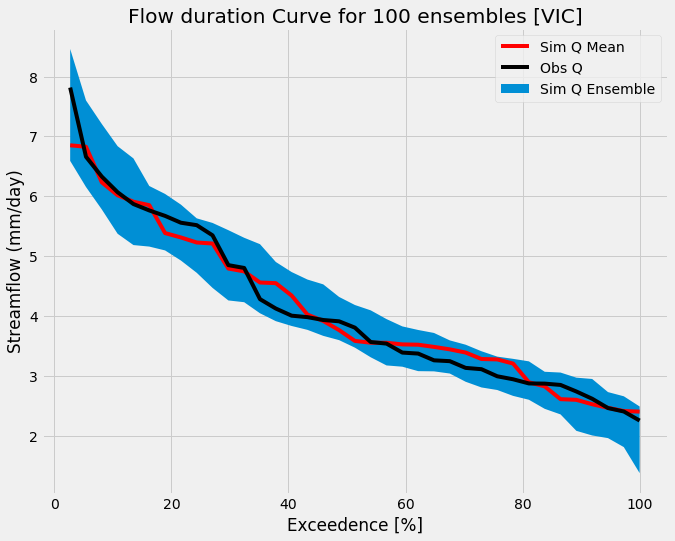

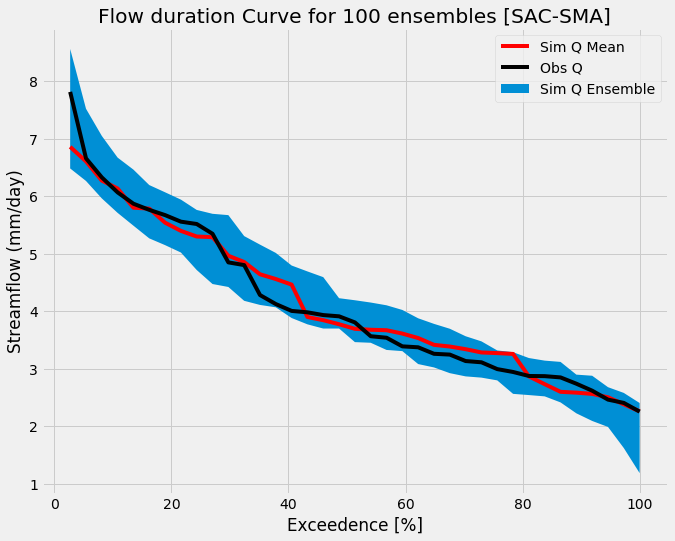

In [22]:
plotfdc(hechmsq, qobs,'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [HEC-HMS]', 'figures/fdcprms.png')
plotfdc(hechmsq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [HEC-HMS]', 'figures/fdchechms.png')
plotfdc(vicq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [VIC]', 'figures/fdcvic.png')
plotfdc(sacsmaq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [SAC-SMA]', 'figures/fdcsacsma.png')

# YEARLY PEAK FLOWS

In [23]:
def plotpeakq(qdat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot exceedances of FUSE model outputs
    '''
    sort = np.flipud(np.sort(qdat, axis=0)[::-1])
    
    # Prepare mean ensemble data
    meanq = qdat.mean(axis=1)
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8)) 
    plt.plot(sort, color='lightblue')
    plt.plot(np.sort(meanq), label = 'Mean Q', color='red')
    plt.plot(np.sort(obsdat), label = 'Obs Q', color='black')
    plt.xlabel('')
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()

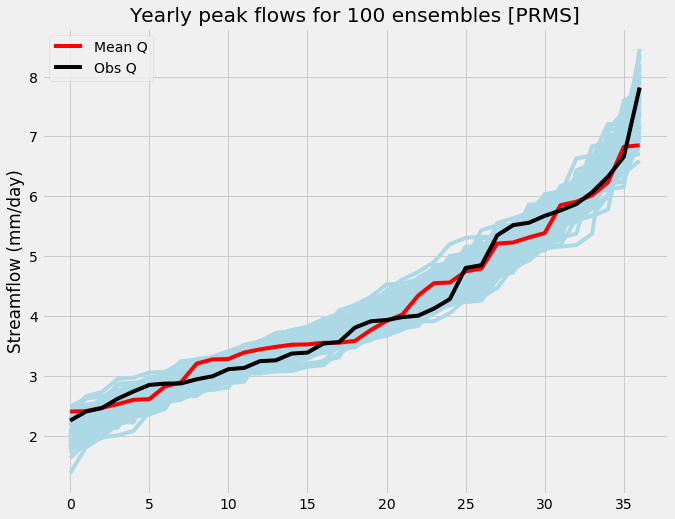

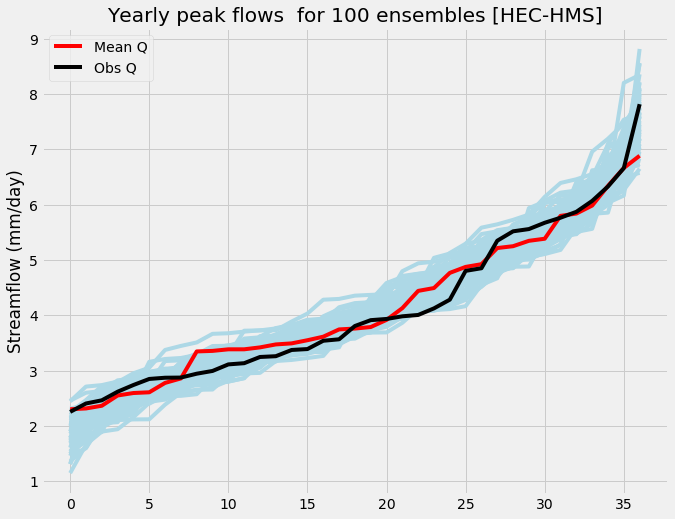

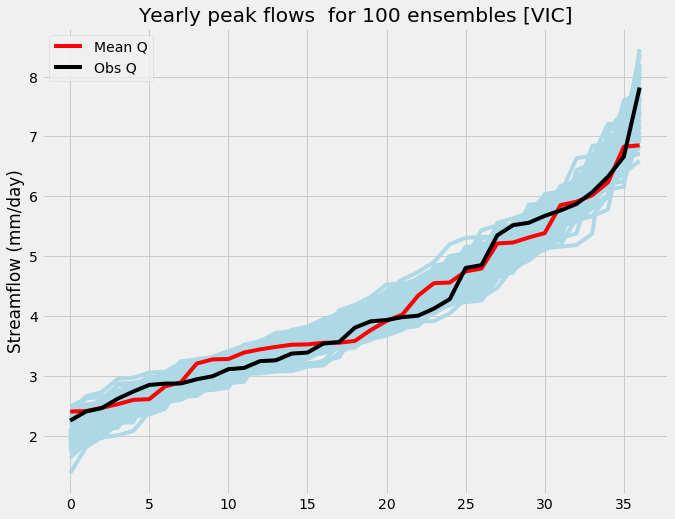

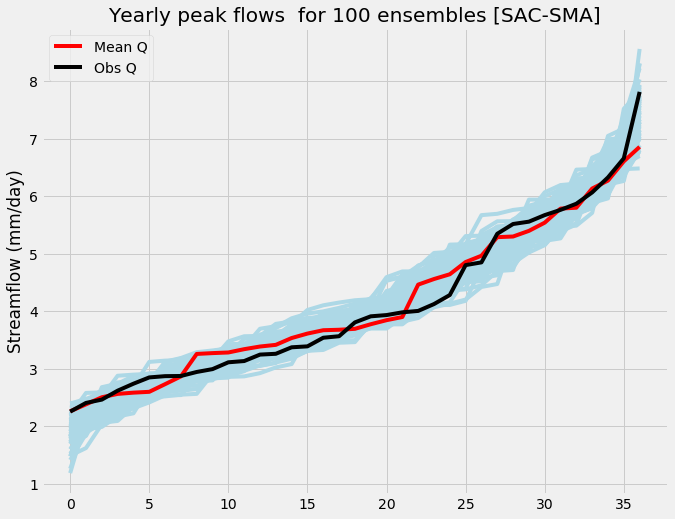

In [24]:
plotpeakq(prmsq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows for 100 ensembles [PRMS]', 'figures/yearlyprms.png')
plotpeakq(hechmsq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [HEC-HMS]', 'figures/yearlyhecshms.png')
plotpeakq(vicq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [VIC]', 'figures/yearlyvic.png')
plotpeakq(sacsmaq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [SAC-SMA]', 'figures/yearlysacsma.png')

# Empirical CDF

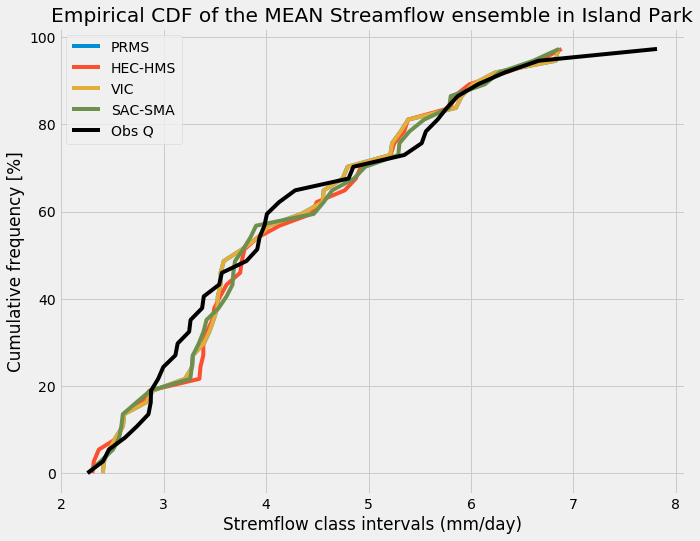

In [28]:
# Empirical CDF
plt.figure(figsize=(10,8))

meanprms = prmsq.mean(axis=1)
meanhechms = hechmsq.mean(axis=1)
meanvic = vicq.mean(axis=1)
meansacsma = sacsmaq.mean(axis=1)

#Q['q_routed'].plot.hist(weights=np.zeros_like(Q['q_routed']) + 100. / Q['q_routed'].size, cumulative=True,edgecolor='#4aaaaa')
plt.plot(np.sort(meanprms), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'PRMS')
plt.plot(np.sort(meanhechms), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'HEC-HMS')
plt.plot(np.sort(meanvic), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'VIC')
plt.plot(np.sort(meansacsma), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'SAC-SMA')
plt.plot(np.sort(qobs), np.linspace(0, 100, len(qobs), endpoint=False), label = 'Obs Q', color = 'black')

plt.ylabel('Cumulative frequency [%]')
plt.xlabel('Stremflow class intervals (mm/day)')
plt.title('Empirical CDF of the MEAN Streamflow ensemble in Island Park')
plt.legend()
plt.savefig('figures/empiricalcdf.png', bbox_inches='tight', dpi=300)
plt.show()

# Compare 2 plots with different KGE values

[[ 0.87888998  0.80766267  0.90730333  0.93853688  0.88831335  0.85403937
   0.8504172   0.85525167  0.8601504   0.89582902  0.86465293  0.90905851
   0.88367677  0.89373499  0.89596778  0.91416019  0.8738097   0.90636718
   0.85753232  0.93671173  0.90201223  0.7940675   0.91409129  0.85772258
   0.87631923  0.9055056   0.89085758  0.75971854  0.83102834  0.87035608
   0.88496417  0.90346682  0.90219432  0.86315292  0.80621517  0.83854252
   0.8595804   0.88665956  0.92849827  0.87940216  0.89912122  0.89825755
   0.74606442  0.8487578   0.85021985  0.83708459  0.88998693  0.85293937
   0.87384862  0.92494631  0.86407983  0.91622007  0.88145876  0.86569309
   0.81431389  0.84799469  0.84680724  0.90842509  0.85149151  0.80788374
   0.89162785  0.87024498  0.87566596  0.91095996  0.83092916  0.90824652
   0.88437355  0.80847144  0.87764597  0.88782239  0.94006479  0.88845599
   0.88360721  0.79544181  0.85020745  0.87546116  0.92894399  0.88841766
   0.85529637  0.85024017  0.92822474 

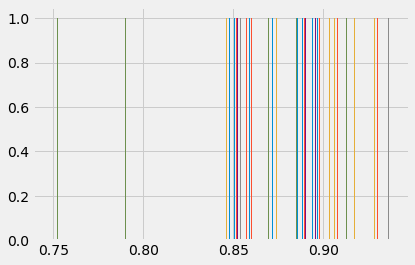

In [27]:
kgeint = vextract(prmsparam, 'kge_int')
print(kgeint)
plt.hist(kgeint)
plt.show()

## Since there are some extreme values below 0.8, let's pick 2 ensembles with KGE values of 0.755 (Ensemble 100) and 0.907 (Ensemble 3). 

## The yearly maximums yield more information on the discrepancies than the complete series plot from 1980-2014.

In [99]:
def yearlyMax(ncfile, ncvar, year):
    '''
    Extracts yearly maximum values from a FUSE output file for a particular variable from a particular year
    
    ncfile: FUSE output file
    ncvar: FUSE variable to be extracted
    year: Year from which values are to be extracted
    '''
    ncdat = xr.open_dataset(ncfile)
    ncdat = ncdat.groupby('time.year').max()
    ncdat = ncdat[ncvar]
    ncdat = ncdat.where((ncdat.year > year), drop = True)
    
    return(ncdat)

ncdatobs = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/003_111_runs_best.nc', 'obsq', 1980)

#PRMS
ncdat003_111 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/003_111_runs_best.nc', 'q_routed', 1980)
ncdat100_111 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/100_111_runs_best.nc', 'q_routed', 1980)

#HEC-HMS
ncdat003_222 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/003_222_runs_best.nc', 'q_routed', 1980)
ncdat100_222 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/100_222_runs_best.nc', 'q_routed', 1980)

#VIC
ncdat003_333 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/003_333_runs_best.nc', 'q_routed', 1980)
ncdat100_333 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/100_333_runs_best.nc', 'q_routed', 1980)

#SAC-SMA
ncdat003_444 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/003_444_runs_best.nc', 'q_routed', 1980)
ncdat100_444 = yearlyMax('/glade/p/work/manab/ff/islandpark/output/allens/100_444_runs_best.nc', 'q_routed', 1980)

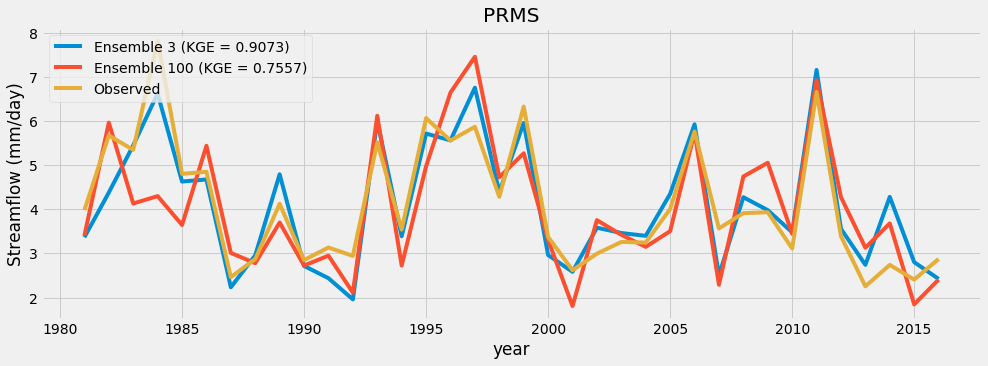

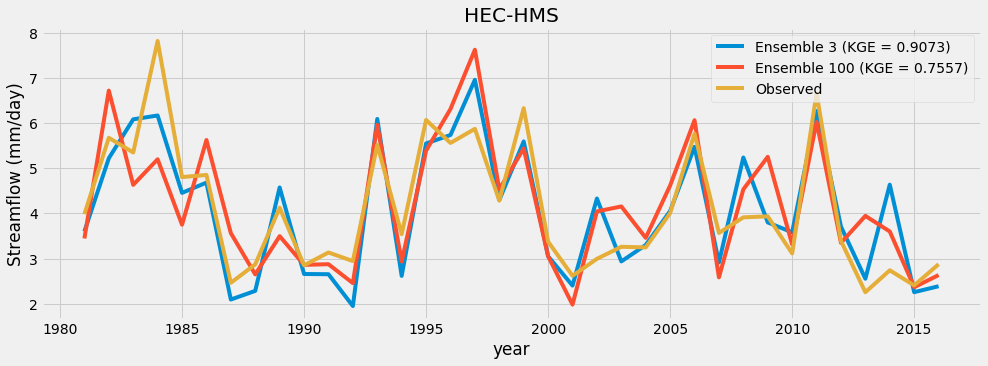

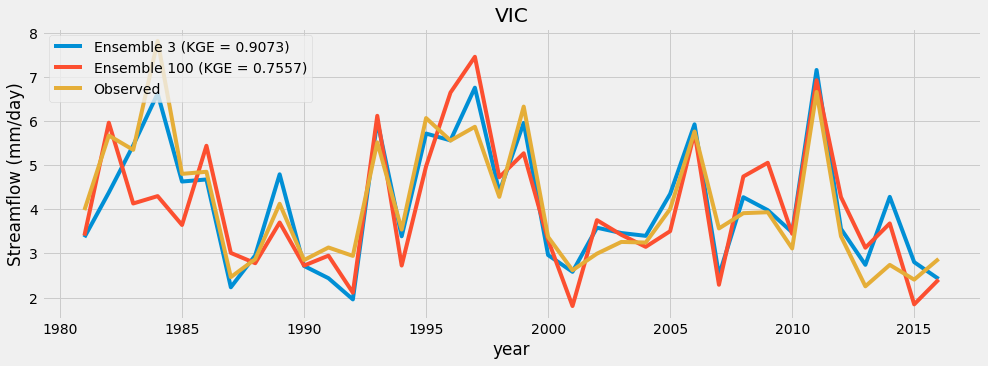

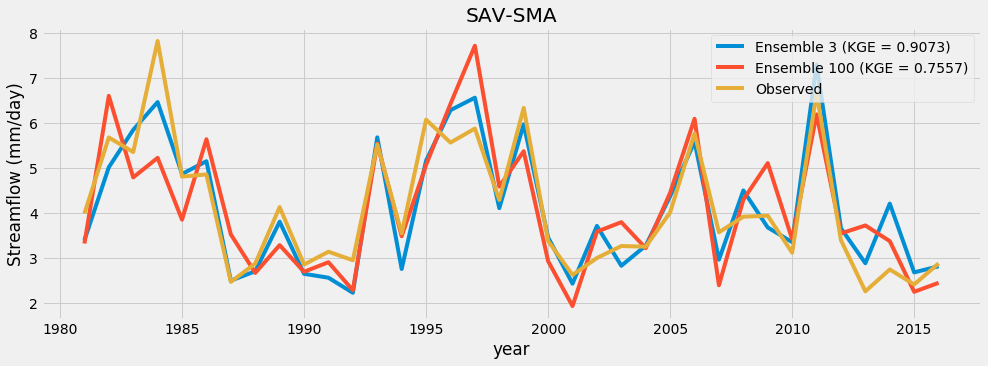

In [100]:
plt.figure(figsize=(15,5))
ncdat003_111.plot(label = 'Ensemble 3 (KGE = 0.9073)')
ncdat100_111.plot(label = 'Ensemble 100 (KGE = 0.7557)')
ncdatobs.plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('PRMS')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
ncdat003_222.plot(label = 'Ensemble 3 (KGE = 0.9073)')
ncdat100_222.plot(label = 'Ensemble 100 (KGE = 0.7557)')
ncdatobs.plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('HEC-HMS')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
ncdat003_333.plot(label = 'Ensemble 3 (KGE = 0.9073)')
ncdat100_333.plot(label = 'Ensemble 100 (KGE = 0.7557)')
ncdatobs.plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('VIC')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
ncdat003_444.plot(label = 'Ensemble 3 (KGE = 0.9073)')
ncdat100_444.plot(label = 'Ensemble 100 (KGE = 0.7557)')
ncdatobs.plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('SAV-SMA')
plt.legend()
plt.show()